In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# import sys
# sys.path.insert(0, '../')

import numpy as np
import tensorflow as tf
import data
import utils
import plot as plots
import evaluation
from model import WGanModel
from gan import CosmoGAN

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"


/home/nati/.virtualenvs/cosmogan-py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Parameters

In [3]:
ns = 32
try_resume = False
Mpch=350

In [4]:
def forward(X):
    return np.log(np.sqrt(X)+np.e)-2

def backward(Xmap, max_value=2e5):
    Xmap = np.clip(Xmap, -1.0, forward(max_value))
    tmp = np.exp((Xmap+2))-np.e
    return np.round(tmp*tmp)

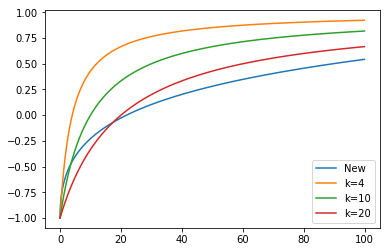

In [5]:
x = np.arange(0,100,0.1)
plt.plot(x,forward(x))
plt.plot(x,utils.forward_map(x,k=4))
plt.plot(x,utils.forward_map(x,k=10))
plt.plot(x,utils.forward_map(x,k=20))
plt.legend(['New','k=4','k=10','k=20'])

# Data handling

Load the data

In [6]:
dataset = data.load.load_dataset(spix=ns, resolution=256,Mpch=Mpch, forward_map=forward)

In [7]:
dataset.get_all_data().shape

(163840, 32, 32)

min: -1.0
max: 4.086443901062012


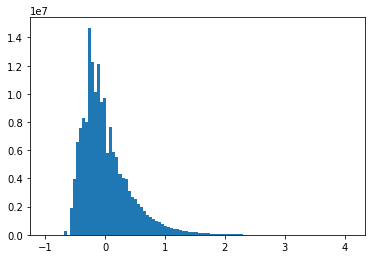

In [8]:
X = dataset.get_all_data()
nel = np.prod(X.shape)
Xvec = np.reshape(X,[nel])
hist(Xvec, 100)
print('min: {}'.format(min(Xvec)))
print('max: {}'.format(max(Xvec)))

Let us plot 16 images

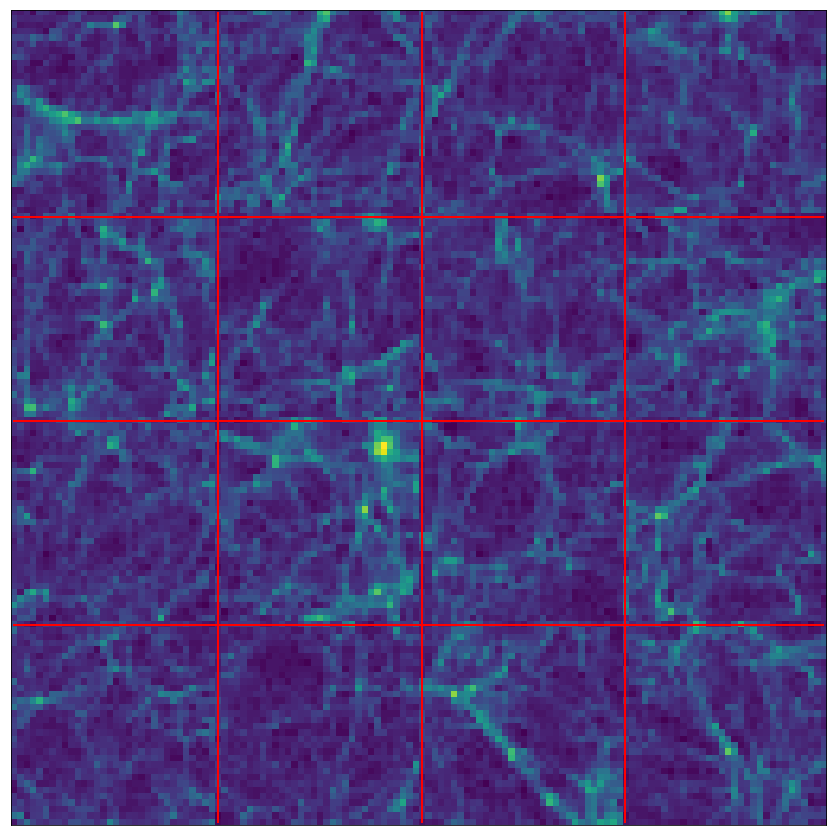

In [9]:
plt.figure(figsize=(15,15))
plots.draw_images(dataset.get_samples(N=16),nx=4,ny=4)

# A) The WGAN

In [10]:
time_str = 'test_{}'.format(Mpch)
global_path = '../../saved_result/'

name = 'WGAN{}'.format(ns)

## Parameters

In [21]:
bn = False

params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2]
params_discriminator['nfilter'] = [16, 32, 32]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5]]
params_discriminator['batch_norm'] = [bn, bn, bn]
params_discriminator['full'] = [32]
params_discriminator['minibatch_reg'] = True
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 1, 1]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [32, 64, 1]
params_generator['shape'] = [[5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [bn, bn]
params_generator['full'] = [16*16*32]
params_generator['summary'] = True
params_generator['non_lin'] = None

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['batch_size'] = 16
params_optimization['gen_optimizer'] = 'rmsprop' # rmsprop / adam / sgd
params_optimization['disc_optimizer'] = 'rmsprop' # rmsprop / adam /sgd
params_optimization['disc_learning_rate'] = 3e-5
params_optimization['gen_learning_rate'] = 3e-5
params_optimization['beta1'] = 0.9
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 2


params_cosmology = dict()
params_cosmology['clip_max_real'] = True
params_cosmology['log_clip'] = 0.1
params_cosmology['sigma_smooth'] = 1
params_cosmology['forward_map'] = forward
params_cosmology['backward_map'] = backward
params_cosmology['Npsd'] = 500


params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization
params['cosmology'] = params_cosmology

params['normalize'] = False
params['image_size'] = [ns, ns]
params['prior_distribution'] = 'gaussian'
params['sum_every'] = 500
params['viz_every'] = 500
params['print_every'] = 100
params['save_every'] = 2000
params['name'] = name
params['summary_dir'] = global_path + params['name'] + '_' + time_str +'_summary/'
params['save_dir'] = global_path + params['name'] + '_' + time_str + '_checkpoints/'

In [22]:
resume, params = utils.test_resume(try_resume, params)

## Build the model

In [23]:
wgan = CosmoGAN(params, WGanModel)

Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 8192 outputs
         Size of the variables: (?, 8192)
     Reshape to (?, 16, 16, 32)
     1 Deconv layer with 32 channels
         Size of the variables: (?, 32, 32, 32)
     2 Deconv layer with 64 channels
         Size of the variables: (?, 32, 32, 64)
     3 Deconv layer with 1 channels
         Size of the variables: (?, 32, 32, 1)
     The output is of size (?, 32, 32, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 32, 32, 1)
     0 Conv layer with 16 channels
         Size of the variables: (?, 16, 16, 16)
     1 Conv layer with 32 channels
         Size of the variables: (?, 8, 8, 32)
     2 Conv layer with 32 channels
         Size of the variables: (?, 4, 4, 32)
     Reshape to (?, 512)
     3 Full layer with 32 outputs
     

## Train the model
Note that the input is the processed data... Maybe, we should change that

In [ ]:
wgan.train(dataset, resume=resume)

Erase recursively directory: ../../saved_result/WGAN32_test_350_summary/
Erase recursively directory: ../../saved_result/WGAN32_test_350_checkpoints/
Epoch: [ 0] [  99/10240] Counter:100	( 0.1 min	214.737 examples/sec	0.07 sec/batch)	L_Disc:-1.61076808	L_Gen:0.85864848
Epoch: [ 0] [ 199/10240] Counter:200	( 0.2 min	313.419 examples/sec	0.05 sec/batch)	L_Disc:-2.79456830	L_Gen:0.11052176
Epoch: [ 0] [ 299/10240] Counter:300	( 0.3 min	314.859 examples/sec	0.05 sec/batch)	L_Disc:-2.85274172	L_Gen:-0.25936776
Epoch: [ 0] [ 399/10240] Counter:400	( 0.4 min	314.300 examples/sec	0.05 sec/batch)	L_Disc:-3.45641828	L_Gen:-0.15640244
Epoch: [ 0] [ 499/10240] Counter:500	( 0.5 min	249.092 examples/sec	0.06 sec/batch)	L_Disc:-1.23592925	L_Gen:-1.01114583
 [*] [Fake, Real] Min [11.952, 1.172],	Median [27.776,16.580],	Mean [2.861E+01,6.473E+01],	Max [6.584E+01,6.861E+03],	Var [7.300E+01,1.724E+05]
 [*] [Comp, Fake, Real] PeakDistance:[1.252, 0.194, 1.380]	CrossPS:[0.104, -1.290, -1.462]
 [*] New PSD

In [15]:
gen_sample, gen_sample_raw = wgan.generate(N=500)
gen_sample = np.squeeze(gen_sample)
gen_sample_raw = np.squeeze(gen_sample_raw)

 [*] Reading checkpoints...
INFO:tensorflow:Restoring parameters from ../../saved_result/WGAN32_test_350_checkpoints/WGAN32-5799


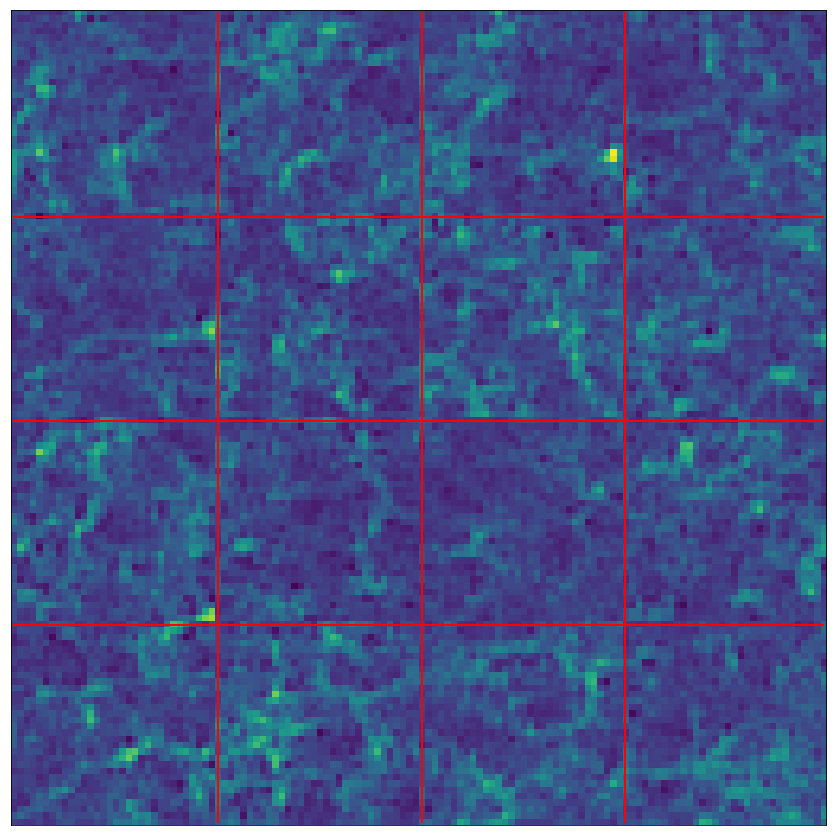

In [16]:
plt.figure(figsize=(15,15))
plots.draw_images(gen_sample,nx=4,ny=4)

In [17]:
raw_images = backward(dataset.get_samples(dataset.N))

Log l2 PSD loss: 3.601443460051035
L2 PSD loss: 21671.262616334563
Log l1 PSD loss: 1.641983191966076
L1 PSD loss: 144.48531204231432


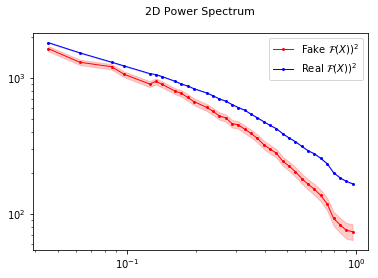

In [18]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_psd(raw_images, gen_sample_raw)

Log l2 Peak Count loss: 3.622652940574169
L2 Peak Count loss: 0.17527939359274514
Log l1 Peak Count loss: 1.3259831134428761
L1 Peak Count loss: 0.2760325439453125


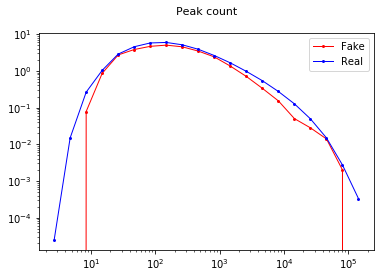

In [19]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_peak_cout(raw_images, gen_sample_raw)

Log l2 Mass histogram loss: 11.132739061926115
L2 Peak Mass histogram: 225.02785629557215
Log l1 Mass histogram loss: 1.621679063066523
L1 Mass histogram loss: 8.064175366210936


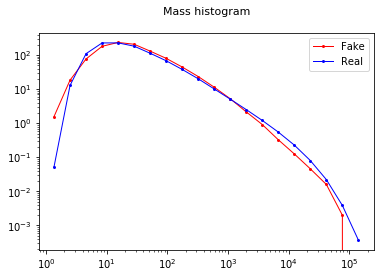

In [20]:
logel2, l2, logel1, l1 = evaluation.compute_and_plot_mass_hist(raw_images, gen_sample_raw)